# Corrective RAG Process: Retrieval-Augmented Generation with Dynamic Correction

## Overview

The Corrective RAG (Retrieval-Augmented Generation) process is an advanced information retrieval and response generation system. It extends the standard RAG approach by dynamically evaluating and correcting the retrieval process, combining the power of vector databases, web search, and language models to provide accurate and context-aware responses to user queries.

## Motivation

While traditional RAG systems have improved information retrieval and response generation, they can still fall short when the retrieved information is irrelevant or outdated. The Corrective RAG process addresses these limitations by:

1. Leveraging pre-existing knowledge bases
2. Evaluating the relevance of retrieved information
3. Dynamically searching the web when necessary
4. Refining and combining knowledge from multiple sources
5. Generating human-like responses based on the most appropriate knowledge

## Key Components

1. **FAISS Index**: A vector database for efficient similarity search of pre-existing knowledge.
2. **Retrieval Evaluator**: Assesses the relevance of retrieved documents to the query.
3. **Knowledge Refinement**: Extracts key information from documents when necessary.
4. **Web Search Query Rewriter**: Optimizes queries for web searches when local knowledge is insufficient.
5. **Response Generator**: Creates human-like responses based on the accumulated knowledge.

## Method Details

1. **Document Retrieval**: 
   - Performs similarity search in the FAISS index to find relevant documents.
   - Retrieves top-k documents (default k=3).

2. **Document Evaluation**:
   - Calculates relevance scores for each retrieved document.
   - Determines the best course of action based on the highest relevance score.

3. **Corrective Knowledge Acquisition**:
   - If high relevance (score > 0.7): Uses the most relevant document as-is.
   - If low relevance (score < 0.3): Corrects by performing a web search with a rewritten query.
   - If ambiguous (0.3 ≤ score ≤ 0.7): Corrects by combining the most relevant document with web search results.

4. **Adaptive Knowledge Processing**:
   - For web search results: Refines the knowledge to extract key points.
   - For ambiguous cases: Combines raw document content with refined web search results.

5. **Response Generation**:
   - Uses a language model to generate a human-like response based on the query and acquired knowledge.
   - Includes source information in the response for transparency.

## Benefits of the Corrective RAG Approach

1. **Dynamic Correction**: Adapts to the quality of retrieved information, ensuring relevance and accuracy.
2. **Flexibility**: Leverages both pre-existing knowledge and web search as needed.
3. **Accuracy**: Evaluates the relevance of information before using it, ensuring high-quality responses.
4. **Transparency**: Provides source information, allowing users to verify the origin of the information.
5. **Efficiency**: Uses vector search for quick retrieval from large knowledge bases.
6. **Contextual Understanding**: Combines multiple sources of information when necessary to provide comprehensive responses.
7. **Up-to-date Information**: Can supplement or replace outdated local knowledge with current web information.

## Conclusion

The Corrective RAG process represents a sophisticated evolution of the standard RAG approach. By intelligently evaluating and correcting the retrieval process, it overcomes common limitations of traditional RAG systems. This dynamic approach ensures that responses are based on the most relevant and up-to-date information available, whether from local knowledge bases or the web. The system's ability to adapt its information sourcing strategy based on relevance scores makes it particularly suited for applications requiring high accuracy and current information, such as research assistance, dynamic knowledge bases, and advanced question-answering systems.

<div style="text-align: center;">

<img src="../images/crag.svg" alt="Corrective RAG" style="width:80%; height:auto;">
</div>

### Import relevant libraries

In [76]:
import os
import sys
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.pydantic_v1 import BaseModel, Field


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Add the parent directory to the path since we work with notebooks
from helper_functions import *
#from evaluation.evalute_rag import *

# Load environment variables from a .env file
load_dotenv()

# Set the OpenAI API key environment variable
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
from langchain.tools import DuckDuckGoSearchResults


### Define files path

In [78]:
path = "../data/Understanding_Climate_Change.pdf"

### Create a vector store

In [79]:
vectorstore = encode_pdf(path)

### Initialize OpenAI language model


In [80]:
llm = ChatOpenAI(model="gpt-4o-mini", max_tokens=1000, temperature=0)

### Initialize search tool

In [81]:
search = DuckDuckGoSearchResults()

### Define retrieval evaluator, knowledge refinement and query rewriter llm chains

In [82]:
# Retrieval Evaluator
class RetrievalEvaluatorInput(BaseModel):
    relevance_score: float = Field(..., description="The relevance score of the document to the query. the score should be between 0 and 1.")
def retrieval_evaluator(query: str, document: str) -> float:
    prompt = PromptTemplate(
        input_variables=["query", "document"],
        template="On a scale from 0 to 1, how relevant is the following document to the query? Query: {query}\nDocument: {document}\nRelevance score:"
    )
    chain = prompt | llm.with_structured_output(RetrievalEvaluatorInput)
    input_variables = {"query": query, "document": document}
    result = chain.invoke(input_variables).relevance_score
    return result

# Knowledge Refinement
class KnowledgeRefinementInput(BaseModel):
    key_points: str = Field(..., description="The document to extract key information from.")
def knowledge_refinement(document: str) -> List[str]:
    prompt = PromptTemplate(
        input_variables=["document"],
        template="Extract the key information from the following document in bullet points:\n{document}\nKey points:"
    )
    chain = prompt | llm.with_structured_output(KnowledgeRefinementInput)
    input_variables = {"document": document}
    result = chain.invoke(input_variables).key_points
    return [point.strip() for point in result.split('\n') if point.strip()]

# Web Search Query Rewriter
class QueryRewriterInput(BaseModel):
    query: str = Field(..., description="The query to rewrite.")
def rewrite_query(query: str) -> str:
    prompt = PromptTemplate(
        input_variables=["query"],
        template="Rewrite the following query to make it more suitable for a web search:\n{query}\nRewritten query:"
    )
    chain = prompt | llm.with_structured_output(QueryRewriterInput)
    input_variables = {"query": query}
    return chain.invoke(input_variables).query.strip()

### Helper function to parse search results


In [83]:
def parse_search_results(results_string: str) -> List[tuple[str, str]]:
    """
    Parse a JSON string of search results into a list of title-link tuples.

    Args:
        results_string (str): A JSON-formatted string containing search results.

    Returns:
        List[Tuple[str, str]]: A list of tuples, where each tuple contains the title and link of a search result.
                               If parsing fails, an empty list is returned.
    """
    try:
        # Attempt to parse the JSON string
        results = json.loads(results_string)
        # Extract and return the title and link from each result
        return [(result.get('title', 'Untitled'), result.get('link', '')) for result in results]
    except json.JSONDecodeError:
        # Handle JSON decoding errors by returning an empty list
        print("Error parsing search results. Returning empty list.")
        return []

### Define sub functions for the CRAG process

In [84]:
def retrieve_documents(query: str, faiss_index: FAISS, k: int = 3) -> List[str]:
    """
    Retrieve documents based on a query using a FAISS index.

    Args:
        query (str): The query string to search for.
        faiss_index (FAISS): The FAISS index used for similarity search.
        k (int): The number of top documents to retrieve. Defaults to 3.

    Returns:
        List[str]: A list of the retrieved document contents.
    """
    docs = faiss_index.similarity_search(query, k=k)
    return [doc.page_content for doc in docs]

def evaluate_documents(query: str, documents: List[str]) -> List[float]:
    """
    Evaluate the relevance of documents based on a query.

    Args:
        query (str): The query string.
        documents (List[str]): A list of document contents to evaluate.

    Returns:
        List[float]: A list of relevance scores for each document.
    """
    return [retrieval_evaluator(query, doc) for doc in documents]

def perform_web_search(query: str) -> tuple[List[str], List[tuple[str, str]]]:
    """
    Perform a web search based on a query.

    Args:
        query (str): The query string to search for.

    Returns:
        Tuple[List[str], List[Tuple[str, str]]]: 
            - A list of refined knowledge obtained from the web search.
            - A list of tuples containing titles and links of the sources.
    """
    rewritten_query = rewrite_query(query)
    web_results = search.run(rewritten_query)
    web_knowledge = knowledge_refinement(web_results)
    sources = parse_search_results(web_results)
    return web_knowledge, sources

def generate_response(query: str, knowledge: str, sources: List[tuple[str, str]]) -> str:
    """
    Generate a response to a query using knowledge and sources.

    Args:
        query (str): The query string.
        knowledge (str): The refined knowledge to use in the response.
        sources (List[Tuple[str, str]]): A list of tuples containing titles and links of the sources.

    Returns:
        str: The generated response.
    """
    response_prompt = PromptTemplate(
        input_variables=["query", "knowledge", "sources"],
        template="Based on the following knowledge, answer the query. Include the sources with their links (if available) at the end of your answer:\nQuery: {query}\nKnowledge: {knowledge}\nSources: {sources}\nAnswer:"
    )
    input_variables = {
        "query": query,
        "knowledge": knowledge,
        "sources": "\n".join([f"{title}: {link}" if link else title for title, link in sources])
    }
    response_chain = response_prompt | llm
    return response_chain.invoke(input_variables).content


### CRAG process


In [85]:
import json

In [86]:
def crag_process(query: str, faiss_index: FAISS) -> str:
    """
    Process a query by retrieving, evaluating, and using documents or performing a web search to generate a response.

    Args:
        query (str): The query string to process.
        faiss_index (FAISS): The FAISS index used for document retrieval.

    Returns:
        str: The generated response based on the query.
    """
    print(f"\nProcessing query: {query}")

    # Retrieve and evaluate documents
    retrieved_docs = retrieve_documents(query, faiss_index)
    eval_scores = evaluate_documents(query, retrieved_docs)
    
    print(f"\nRetrieved {len(retrieved_docs)} documents")
    print(f"Evaluation scores: {eval_scores}")

    # Determine action based on evaluation scores
    max_score = max(eval_scores)
    sources = []
    
    if max_score > 0.7:
        print("\nAction: Correct - Using retrieved document")
        best_doc = retrieved_docs[eval_scores.index(max_score)]
        final_knowledge = best_doc
        sources.append(("Retrieved document", ""))
    elif max_score < 0.3:
        print("\nAction: Incorrect - Performing web search")
        final_knowledge, sources = perform_web_search(query)
    else:
        print("\nAction: Ambiguous - Combining retrieved document and web search")
        best_doc = retrieved_docs[eval_scores.index(max_score)]
        # Refine the retrieved knowledge
        retrieved_knowledge = knowledge_refinement(best_doc)
        web_knowledge, web_sources = perform_web_search(query)
        final_knowledge = "\n".join(retrieved_knowledge + web_knowledge)
        sources = [("Retrieved document", "")] + web_sources

    print("\nFinal knowledge:")
    print(final_knowledge)
    
    print("\nSources:")
    for title, link in sources:
        print(f"{title}: {link}" if link else title)

    # Generate response
    print("\nGenerating response...")
    response = generate_response(query, final_knowledge, sources)

    print("\nResponse generated")
    return response

### Example query with high relevance to the document


In [87]:
query = "What are the main causes of climate change?"
result = crag_process(query, vectorstore)
print(f"Query: {query}")
print(f"Answer: {result}")


Processing query: What are the main causes of climate change?


/Users/tatsa/miniforge3/envs/ecc/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1660: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/Users/tatsa/miniforge3/envs/ecc/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1660: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/Users/tatsa/miniforge3/envs/ecc/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1660: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema o


Retrieved 3 documents
Evaluation scores: [0.9, 0.9, 0.6]

Action: Correct - Using retrieved document

Final knowledge:
driven by human activities, particularly the emission of greenhou se gases.  
Chapter 2: Causes of Climate Change  
Greenhouse Gases  
The primary cause of recent climate change is the increase in greenhouse gases in the 
atmosphere. Greenhouse gases, such as carbon dioxide (CO2), methane (CH4), and nitrous 
oxide (N2O), trap heat from the sun, creating a "greenhouse effect." This effect is  essential 
for life on Earth, as it keeps the planet warm enough to support life. However, human 
activities have intensified this natural process, leading to a warmer climate.  
Fossil Fuels  
Burning fossil fuels for energy releases large amounts of CO2. This includes coal, oil, and 
natural gas used for electricity, heating, and transportation. The industrial revolution marked 
the beginning of a significant increase in fossil fuel consumption, which continues to rise 
today.  

In [88]:
path = "../data/Understanding_Climate_Change.pdf"

### Example query with low relevance to the document


In [89]:
query = "how did harry beat quirrell?"
result = crag_process(query, vectorstore)
print(f"Query: {query}")
print(f"Answer: {result}")


Processing query: how did harry beat quirrell?


/Users/tatsa/miniforge3/envs/ecc/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1660: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/Users/tatsa/miniforge3/envs/ecc/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1660: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/Users/tatsa/miniforge3/envs/ecc/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1660: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema o


Retrieved 3 documents
Evaluation scores: [0.0, 0.0, 0.0]

Action: Incorrect - Performing web search


/Users/tatsa/miniforge3/envs/ecc/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1660: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/Users/tatsa/miniforge3/envs/ecc/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1660: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


Error parsing search results. Returning empty list.

Final knowledge:
["- Harry faces multiple challenges including a three-headed dog, Devil's Snare, and a life-sized game of wizard chess.", "- Harry defeats Professor Quirrell, who is ultimately killed by Harry's touch, which burns him.", "- Quirrell disintegrates into ash and dust, marking Harry's first kill and victory.", "- Quirrell explains that Snape hates Harry due to a rivalry with Harry's father, James Potter.", "- The Mirror of Erised is revealed as the key to finding the Philosopher's Stone.", "- Quirrell could initially shake Harry's hand because Voldemort had not yet possessed him at that time.", "- Quirrell is not a Horcrux as he did not possess a part of Voldemort's soul."]

Sources:

Generating response...

Response generated
Query: how did harry beat quirrell?
Answer: Harry Potter defeats Professor Quirrell in "Harry Potter and the Philosopher's Stone" through a combination of circumstances and a unique magical connect

## Showing the chunk screenshot

=== Chunk 1 ===
Chunk text (page 1):

1 
 Multi -page Tables (Tables Continued ) 
 This is an example of how to format tables and fi gures that span multiple pages. For 
the first appearance of any  table , you should include the table title/number fo llowed by the 
entire caption.  There must be some formatting that separates the title  from th e caption; you 
can bold the title, italicize the title, or add punctuation (a period or colon)  between the title 
and caption. Yo u can also bold or italicize the title and use punctuation to clearly separate  
these two elements.  However, you should not bold or  italicize the caption, as these are meant 
to add emphasis and make  text more  difficult to read.  
 For example: Table 1. This is an example caption .  
If a table does not fit on one page or is split into two parts by the page break, you must 
inclu de the title and full caption before the table starts, as is standard. For any subsequent

--- Page Screenshot ---



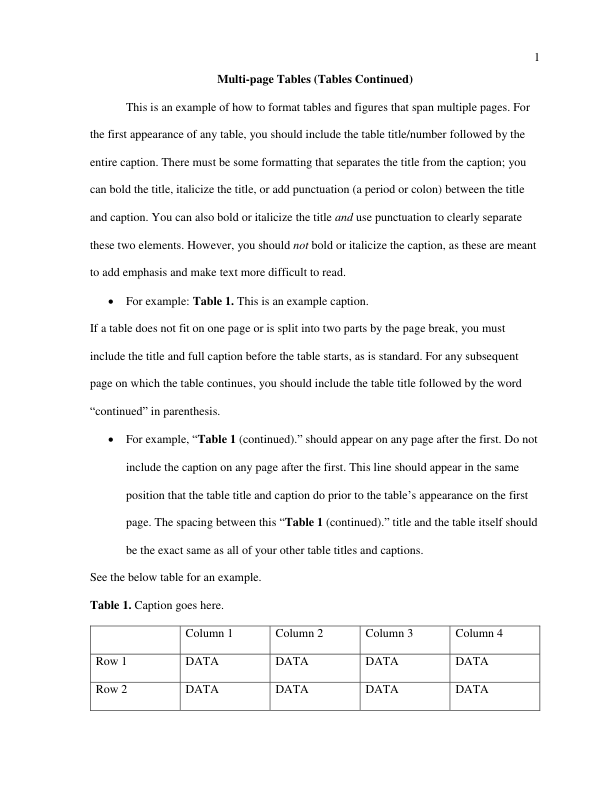

=== Chunk 2 ===
Chunk text (page 1):

If a table does not fit on one page or is split into two parts by the page break, you must 
inclu de the title and full caption before the table starts, as is standard. For any subsequent 
page on w hich the table continues, you should include the table title followed by the word 
“continued ” in parenthesis.  
 For example, “Table 1 (continued) .” should appear  on any page after the first. Do not 
include the caption on any page after the first. This line should appear in the same 
position that the table t itle and caption do prior to the table ’s appearance on the  first 
page. The spacing between this “Table 1  (continue d).” title and the table itself should 
be the exact same as all of your other table titles and captions.  
See the below table for an example.  
Table 1 . Caption goes here.  
 Column 1  Column 2  Column 3  Column 4  
Row 1  DATA  DATA  DATA  DATA  
Row 2  DATA  DATA  DATA  DATA

--- Page Screenshot ---



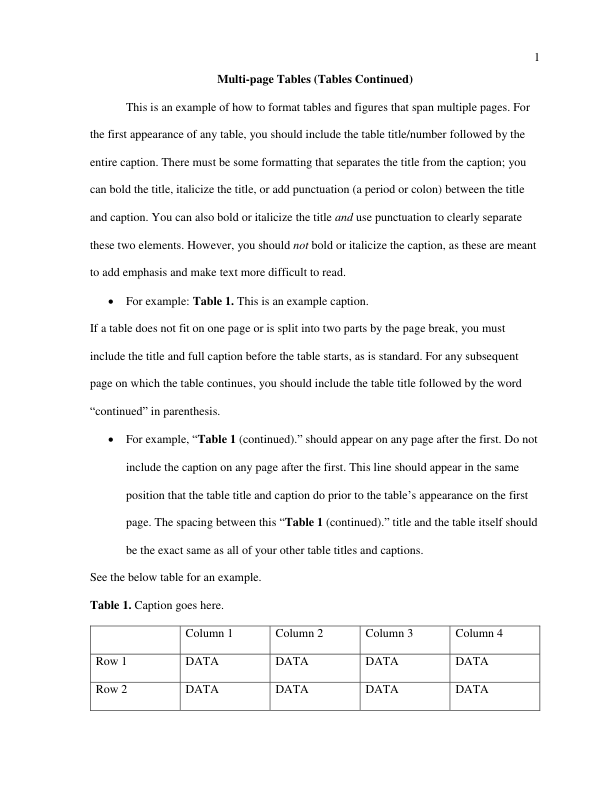

=== Chunk 3 ===
Chunk text (page 2):

2 
 Table 1 (continued).  
 
Row 3  DATA  DATA  DATA  DATA  
Row 4  DATA  DATA  DATA  DATA  
 
In or der to type the t able and “continued ” caption  above the table that appears on a new page , 
you must split the table . Above, I clicked in the first cell of “Row 3 ,” and selected the “Split 
Table ” icon on the “Merge ” section of the “Layout ” tab.  
 
Multi -page Figures  (Figures  Continued ) 
 There is a different standard for formatting figures that span multiple pages. If a 
figure  has multiple parts and  canno t fit on one p age, you must first center  the figure  title and 
caption on its own page . The figure, for however many pages it takes, should appear after 
this pa ge. See the following pages for an example.

--- Page Screenshot ---



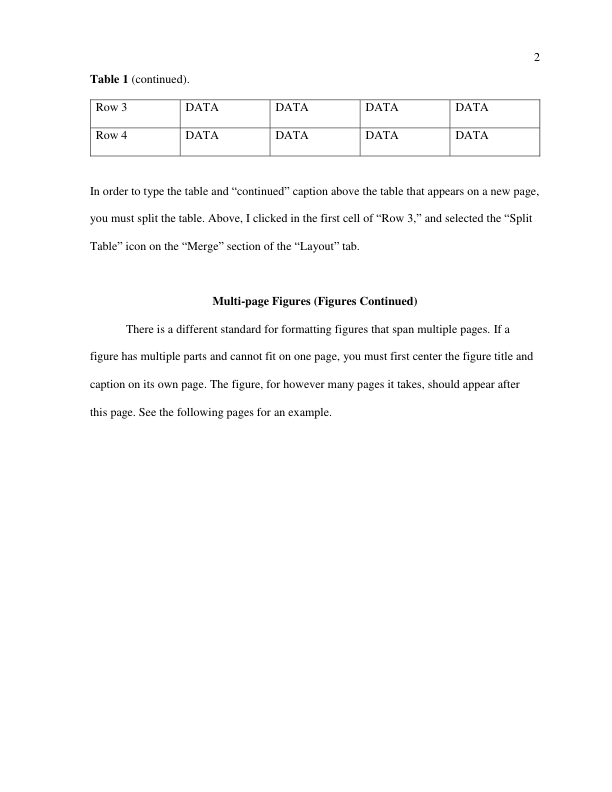

=== Chunk 4 ===
Chunk text (page 3):

3 
  
 
 
 
 
 
 
 
 
Figure 1.  Include the entire caption on this page. The text should be centered horizontally 
and vertically on the page. If you ’ve chosen to space your captions differently than your body 
text, you can do so here as well (in this example, it is double -spaced). The figure should start 
on the next page.  For this example, this figure is made up of four cha rts (A through D).

--- Page Screenshot ---



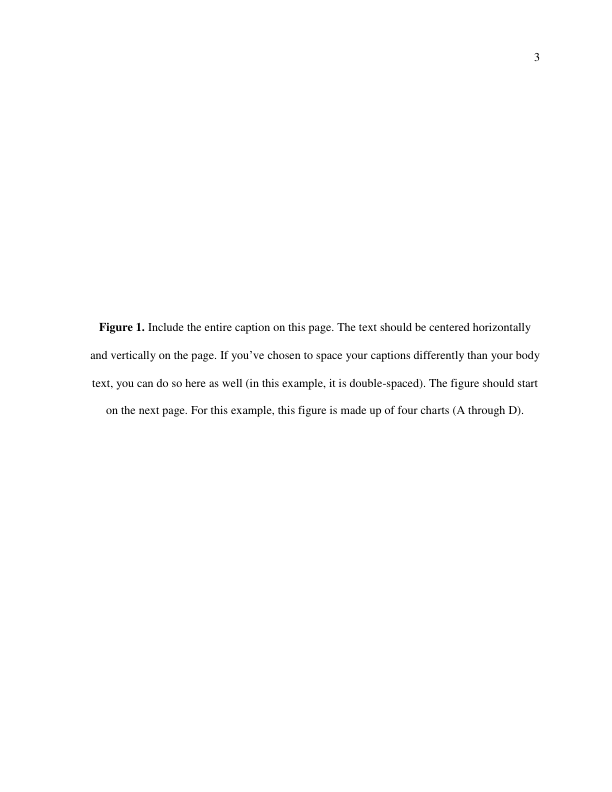

=== Chunk 5 ===
Chunk text (page 4):

4 
  
 
 
 
  0123456
Category 1 Category 2 Category 3 Category 4Chart A
Series 1 Series 2 Series 3
0123456
Category 1 Category 2 Category 3 Category 4Chart B
Series 1 Series 2 Series 3

--- Page Screenshot ---



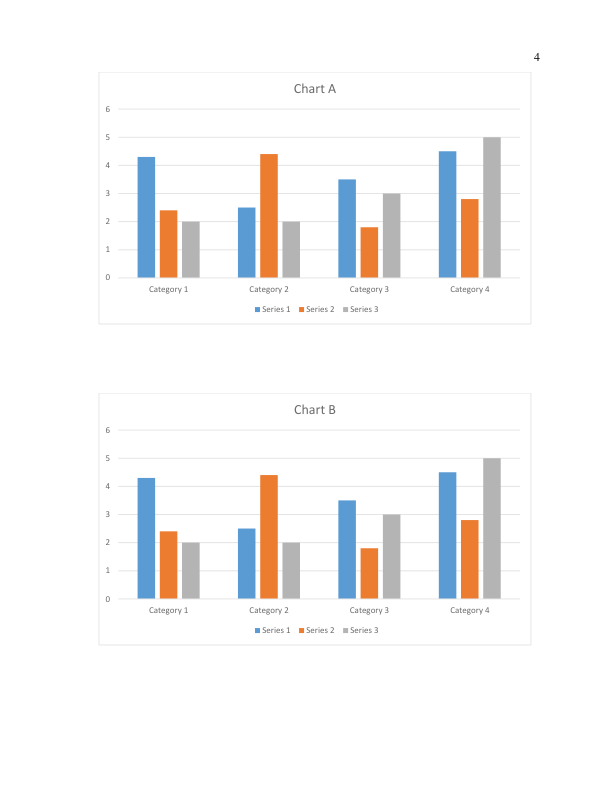

=== Chunk 6 ===
Chunk text (page 5):

5 
  
 
 
 0123456
Category 1 Category 2 Category 3 Category 4Chart C
Series 1 Series 2 Series 3
0123456
Category 1 Category 2 Category 3 Category 4Chart D
Series 1 Series 2 Series 3

--- Page Screenshot ---



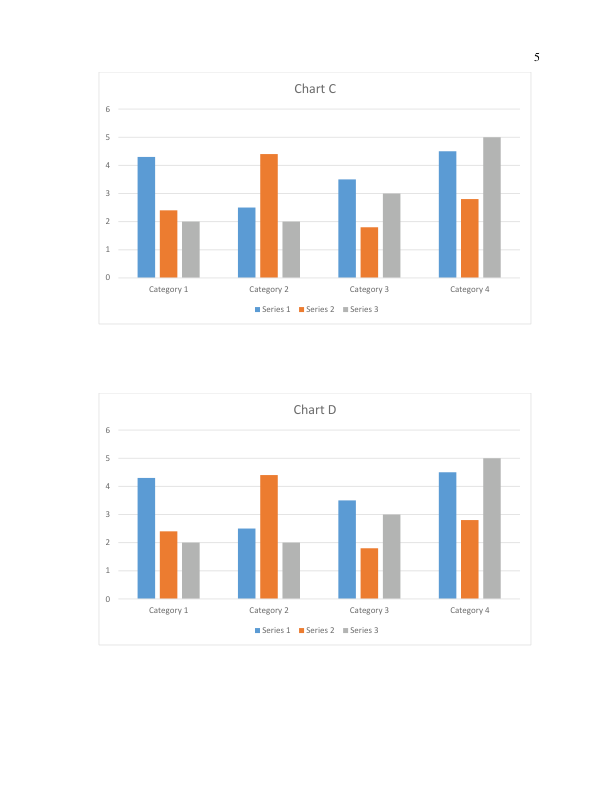

In [95]:
import fitz  # PyMuPDF
from IPython.display import display, Image
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

def chunk_pdf(pdf_path, chunk_size=1000, chunk_overlap=200):
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len
    )
    return text_splitter.split_documents(documents)

def show_chunk_and_page(chunk, pdf_path):
    doc = fitz.open(pdf_path)
    page_num = chunk.metadata.get('page', 0)
    page = doc[page_num]
    # Show chunk text
    print(f"Chunk text (page {page_num+1}):\n")
    print(chunk.page_content)
    print("\n--- Page Screenshot ---\n")
    # Show full page image
    pix = page.get_pixmap()
    display(Image(data=pix.tobytes("png")))
    doc.close()

# Example usage:
pdf_path = "../data/sample.pdf"
chunks = chunk_pdf(pdf_path)
for i, chunk in enumerate(chunks):
    print(f"=== Chunk {i+1} ===")
    show_chunk_and_page(chunk, pdf_path)